# Backtests on GMV and ERC portfolios

[Backtesting function](#backtest)

[Equal weights portfolio](#ew)

[Global Minimum Variance portfolios](#gmv)
- [Sample variance GMV](#samplegmv)
- [Constant correlation GMV](#ccgmv)
- [Statistical Shrinkage GMV](#shrink)

[Equal Risk Contribution portfolio](#erc)

[Comparing portfolios](#comp)

In [1]:
%load_ext autoreload
%autoreload 2

from finance_utils import *

import pandas as pd
import numpy as np

In [2]:
df_cac40 = pd.read_pickle('./cac40_data/df_cac40.pkl')
df_cac40_rets = df_cac40.pct_change().dropna() # drop 1st line containing NaNs

df_cac40_stocks = pd.read_pickle('./cac40_data/df_cac40_stocks.pkl')
df_cac40_stocks_rets = df_cac40_stocks.pct_change().dropna()

# annualized data
rets = annualize_rets(df_cac40_stocks_rets, 252)
cov = df_cac40_stocks_rets.cov()

# Backtesting function<a id='backtest'></a>

Backtesting a weighting scheme : `backtest_ws(r, estimation_window, weighting, **kwargs)` requires asset returns `r`, an `estimation_window` in time for estimating parameters, and a `weighting` scheme

In [3]:
def backtest_ws(r, estimation_window, weighting, **kwargs):
    """
    Backtests a given weighting scheme, given some parameters:
    
    r : asset returns to use to build the portfolio
    
    estimation_window: the window to use to estimate parameters.
    It is a sliding window of length `estimation_window` (in whatever unit of time is used for the returns).
    The window moves ahead in time for each time unit of the returns(days, months...), and for
    every new position of the windows, portfolio is rebalanced according to the recalculated weights
    
    weighting: the weighting scheme to use, must be a function that takes "r", 
    and a variable number of keyword-value arguments (**kwargs)
    """
    n_periods = r.shape[0]
    
    # windows is a list of tuples which gives us the (integer) location of the start and stop (non inclusive)
    # for estimation_window=60 we have : windows = [(0, 60), (1, 61), ...]
    windows = [(start, start+estimation_window) for start in range(n_periods-estimation_window+1)]
    
    # DataFrame containing weights for each asset for all dates at the end of the sliding window
    # Its size is (n_periods - estimation_window + 1) x (number of assets)
    weights = [weighting(r.iloc[win[0]:win[1]], **kwargs) for win in windows]
    
    # convert to a DataFrame starting at the end of the first estimation window,
    weights = pd.DataFrame(weights, index=r.iloc[estimation_window-1:].index, columns=r.columns)
    
    # returns = weighted sum of returns accross all assets
    # Note that weights are only available starting at t=`estimation_window`, since 
    # all returns of initial estimation_window (for t = 0 ... estimation_window)
    # were used to calculate the weights at t=estimation_window.
    # So the first `estimation_window` points of `returns` will be NaNs.
    returns = (weights * r).sum(axis="columns",  min_count=1) #mincount is to generate NAs if all inputs are NAs
    
    return returns

`estimation_window` used for all portfolios therafter

In [4]:
estimation_window = 30 # parameters are estimated over 30 days for this dataset

# EW portfolio<a id='ew'></a>

In [5]:
# Weighting scheme for an Equal weights portfolio
def weight_ew(r):
    """
    Weighting function used in backtest_ws().
    Returns the weights of the EW portfolio based on the asset returns "r" as a DataFrame
    """
    n = len(r.columns)
    return pd.Series(1/n, index=r.columns)

In [6]:
ew_r = backtest_ws(df_cac40_stocks_rets,
                   estimation_window=estimation_window,
                   weighting=weight_ew)

Returns during first `estimation_window` - 1 days are `NaN`, because they are used to calculate the return on the last day of the window

In [7]:
ew_r.head(3)

Date
2021-09-21   NaN
2021-09-22   NaN
2021-09-23   NaN
dtype: float64

In [8]:
len(ew_r) - len(ew_r.dropna())

29

Weighted portfolio returns are calculated starting from `estimation_window` business days after beginning of original portfolio `df_cac40_stocks_rets`

In [9]:
ew_r.dropna().head(3)

Date
2021-11-01    0.007522
2021-11-02    0.004086
2021-11-03    0.005492
dtype: float64

### Benchmark on CAC40 index

returns from CAC40 index from starting date of benchmarked portfolios

In [10]:
start_date = ew_r.dropna().index[0]
start_date # starting date of all portfolios

Timestamp('2021-11-01 00:00:00')

In [14]:
# Benchmark DataFrame
# .loc[start_date:] to start at `start_date`
btr = pd.DataFrame({"CAC40 index (Cap Weighted)": df_cac40_rets['cac40_index'],
                    "Equal Weights": ew_r, 
                    }).loc[start_date:].dropna()

# .dropna() to drop NaNs in CAC40 index (some dates are missing even though the assets were traded)
summary_stats(btr, riskfree_rate=0.00, periods_per_year=252)

,Annualized Return,Annualized Vol,Skewness,Excess Kurtosis,Sharpe Ratio,Max Drawdown,Cornish-Fisher VaR (5%),Historic CVaR (5%)
CAC40 index (Cap Weighted),0.027883,0.194079,0.033209,3.744227,0.143667,-0.230398,0.018867,0.028553
Equal Weights,0.002728,0.190089,0.009646,3.468375,0.014354,-0.245809,0.018723,0.028281


<Axes: title={'center': 'Backtesting Portfolios'}>

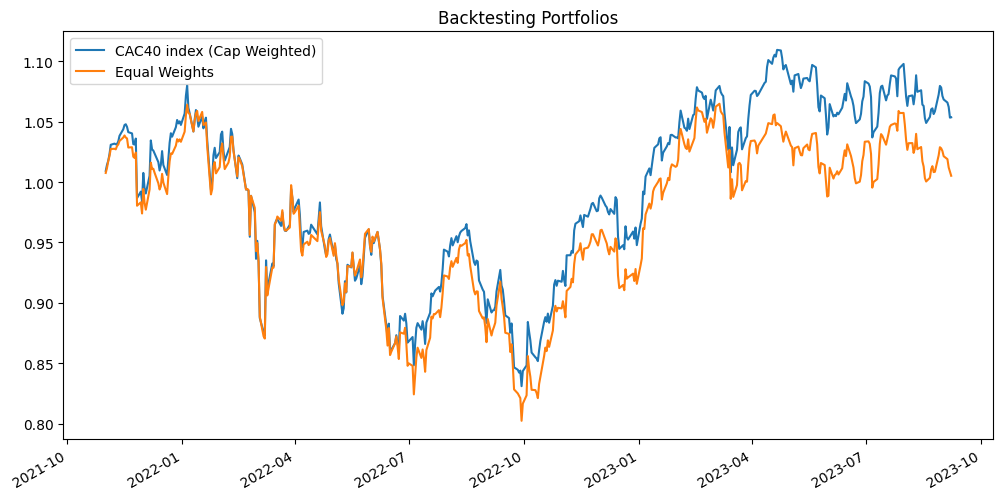

In [16]:
(1 + btr).cumprod().plot(figsize=(12,6), title="Backtesting Portfolios")

# GMV portfolios<a id='gmv'></a>

## Sample variance GMV<a id='samplegmv'></a>

CAC40 = 40 stocks, so we need 40 expected returns, 40 volatilities and 40*39/2=780 correlations to build the covariance matrix... but we only have ~500 days of stock returns

So backtesting the GMV with sample covariance as below isn't very useful (and because of the small sample size, results will change a lot depending on values of `estimation_window`)

In [17]:
# GMV portfolio using sample covariance
def sample_cov(r, **kwargs):
    """
    Returns the sample covariance of the supplied returns
    Uses the average of the returns... so it should be fed with a lot of data
    """
    return r.cov()

def weight_gmv(r, cov_estimator, **kwargs):
    """
    Weighting function used in backtest_ws().
    Produces the weights of the GMV portfolio given a covariance matrix of the returns 
    cov_estimator = matrix that is used to estimate the covariance
    """
    est_cov = cov_estimator(r, **kwargs)
    return gmv(est_cov)

In [18]:
gmv_sample_r = backtest_ws(df_cac40_stocks_rets,
                           estimation_window=estimation_window, 
                           weighting=weight_gmv,
                           cov_estimator=sample_cov)

## Constant correlation GMV<a id='ccgmv'></a>

The general term of the covariance matrix is $\rho_{ij}\sigma_{i}\sigma_{j}$, which requires estimating all the $\rho_{ij}$.

The constant correlation GMV portfolio uses a unique correlation coefficient estimator given by:
$$\hat{\rho}=\frac{1}{N(N-1)}\sum \hat{\rho_{ij}}$$
where$ \hat{\rho_{ij}}$ is the sample estimate of correlation coefficient between assets $i$ and $j$.

The general term of the covariance matrix is now $\hat{\rho}\sigma_{i}\sigma_{j}$, which requires much less parameters to estimate.

(Elton & Gruber, J. Finance, **28**, 5 (1973) showed that this portfolio gives better results than when using sample covariance)

In [19]:
def cc_cov(r, **kwargs):
    """
    Estimates a covariance matrix by using the Elton/Gruber Constant Correlation model
    """
    rhos = r.corr()
    n = rhos.shape[0]
    # this is a symmetric matrix with diagonals all 1 - so the mean correlation is ...
    rho_bar = (rhos.values.sum()-n)/(n*(n-1))
    ccor = np.full_like(rhos, rho_bar)
    np.fill_diagonal(ccor, 1.)
    sd = r.std()
    ccov = ccor * np.outer(sd, sd)
    return pd.DataFrame(ccov, index=r.columns, columns=r.columns)

In [20]:
gmv_cc_r = backtest_ws(df_cac40_stocks_rets,
                       estimation_window=estimation_window,
                       weighting=weight_gmv,
                       cov_estimator=cc_cov)

## Statistical Shrinkage GMV<a id='shrink'></a>

Covariance matrix estimate is given by :
$$\hat{S}_{shrink} = \delta \hat{F} +  (1-\delta) \hat{S}$$

where $\hat{F}$ is an estimate using a factor model (has model risk) and $\hat{S}$ is an estimate using samples (has sample risk but no model risk).

From $\text{Ledoit & Wolf (2003) } \textit{Honey, I Shrunk the Sample Covariance Matrix}$ (http://www.ledoit.net/honey.pdf). Portfolio using shrinkage works better than either $\hat{F}$ or $\hat{S}$ portfolios.

$\text{Jagannathan, R. and Ma, T. (2003), Journal of Finance, 54(4):1651–1684.}$ show that shrinkage is equivalent to imposing constraints on weights. 

Intuition : $\hat{F}$ portfolio has structure and low parameter variance, whereas $\hat{S}$ portfolio parameters depend on data and can have very high variance. Mixing both is equivamlent to constraining parameters of $\hat{S}$ portfolio.

In [21]:
def shrinkage_cov(r, delta, **kwargs):
    """
    Covariance estimator that shrinks between the Sample Covariance and the Factor Estimators.
    Constant Correlation is chosen as the Factor estimator for the covariance matrix.
    delta often set to 0.5 in practice.
    """
    factor = cc_cov(r, **kwargs)
    sample = sample_cov(r, **kwargs)
    return delta*factor + (1-delta)*sample

In [22]:
gmv_shrink = backtest_ws(df_cac40_stocks_rets,
                       estimation_window=estimation_window,
                       weighting=weight_gmv,
                       cov_estimator=shrinkage_cov, delta=0.5)

In [46]:
# Benchmark DataFrame
# .loc[start_date:] to start at `start_date`
btr = pd.DataFrame({"CAC40 index (Cap Weighted)": df_cac40_rets['cac40_index'],
                    "Equal Weights": ew_r, 
                    "GMV-Sample": gmv_sample_r,
                    "GMV-CC":gmv_cc_r, 
                    "GMV-shrink 0.5":gmv_shrink
                    }).loc[start_date:].dropna()

# .dropna() to drop NaNs in CAC40 index (some dates are missing even though the assets were traded)
summary_stats(btr, riskfree_rate=0.00, periods_per_year=252)

,Annualized Return,Annualized Vol,Skewness,Excess Kurtosis,Sharpe Ratio,Max Drawdown,Cornish-Fisher VaR (5%),Historic CVaR (5%)
CAC40 index (Cap Weighted),0.027883,0.194079,0.033209,3.744227,0.143667,-0.230398,0.018867,0.028553
Equal Weights,0.002728,0.190089,0.009646,3.468375,0.014354,-0.245809,0.018723,0.028281
GMV-Sample,0.121364,0.079804,-0.164596,1.291666,1.520780,-0.168579,0.007895,0.010874
GMV-CC,0.077551,0.108695,-0.290896,2.013417,0.713476,-0.189235,0.011208,0.015384
GMV-shrink 0.5,0.094871,0.094762,-0.326988,2.145043,1.001150,-0.168936,0.009715,0.013325


<Axes: title={'center': 'Backtesting Portfolios'}>

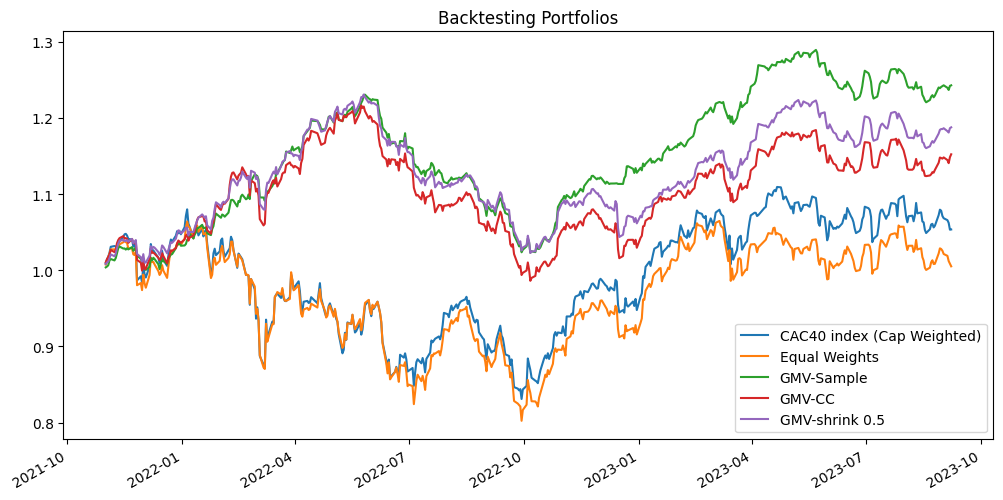

In [47]:
(1 + btr).cumprod().plot(figsize=(12,6), title="Backtesting Portfolios")

VaR of GMV portfolio is smaller than EW or index because of smaller kurtosis (distrib is more peaked)

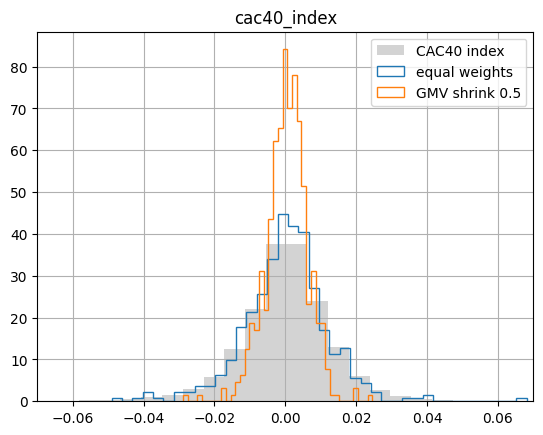

In [25]:
bins = 40
lw = 1.0
ax = df_cac40_rets.hist(bins=bins, density=True, lw=lw,  label='CAC40 index', color = "lightgrey")
ax = ew_r.hist(bins=bins, density=True, lw=lw, histtype='step', label='equal weights')
#ax = gmv_sample_r.hist(bins=bins, density=True, lw=lw, histtype='step', label='GMV sampled')
#ax = gmv_cc_r.hist(bins=bins, density=True, lw=lw, histtype='step', label='GMV CC')
ax = gmv_shrink.hist(bins=bins, density=True, lw=lw, histtype='step', label='GMV shrink 0.5')
ax.set_xlim(-0.07, 0.07)
ax.legend()

# ERC portfolios<a id='erc'></a>

For a portfolio comprising of several assets with different weights, the effective number of constituents is given by:
    $$\text{ENC}=(\sum_i w_i^2)^{-1}$$
    
For S&P500, ENC ~ 100 (there are ~100 components with higher weights responsible for most of the index performance).

Risk parity portfolios maximizes the ENC applied to risk contrib as opposed to $ contrib

Portfolio variance is given by: $$\sigma_p^2=\sum_i \sum_j w_i w_j \sigma_{ij}$$
where $\sigma_{ij}=\rho_{ij}\sigma_i \sigma_j$.
It can be split into 2 contributions: one from the variance of each asset $i$, and one from the covariance between any pair of assets: $$\sigma_p^2= \sum_i w_i^2 \sigma_{i}^2 + \sum_i\sum_{j \neq i} w_i w_j \sigma_{ij}$$

Risk parity weights are given by:
$$p_i=\frac{w_i \sigma_{i}^2 + \sum_{i \neq j} w_i w_j \sigma_{ij}}{\sigma_p^2}$$

`risk_contribution(w,cov)` implements calculation of the $p_i$:
- `total_portfolio_var = portfolio_vol(w,cov)**2` $=\textbf{w}^T\Sigma\textbf{w}$, which is a scalar
- `marginal_contrib = cov@w` $=\Sigma\textbf{w}$ which is a vector of which $i$-th component is $\sum_j w_j \sigma_{ij}$
- `risk_contrib = np.multiply(marginal_contrib,w.T)/total_portfolio_var` makes the Hadamard product $\Sigma\textbf{w} \odot \textbf{w}$ which returns a vector of which $i$-th component is $\sum_j w_i w_j \sigma_{ij} = w_i \sigma_{i}^2 + \sum_{j \neq i} w_i w_j \sigma_{ij}$ (and then divided by $\sigma_p^2$)


In [26]:
def risk_contribution(w, cov):
    """
    Compute the contributions to risk of the constituents of a portfolio,
    given a set of portfolio weights and a covariance matrix
    """
    total_portfolio_var = portfolio_vol(w,cov)**2
    # Marginal contribution of each constituent
    marginal_contrib = cov@w 
    risk_contrib = np.multiply(marginal_contrib,w.T)/total_portfolio_var 
    return risk_contrib

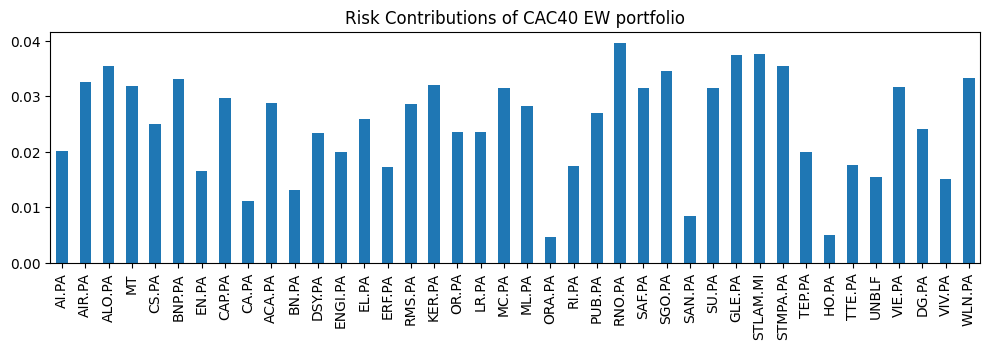

In [27]:
risk_contribution(weight_ew(df_cac40_stocks_rets), cov).plot.bar(title="Risk Contributions of CAC40 EW portfolio", 
                                                                 figsize=(12,3));

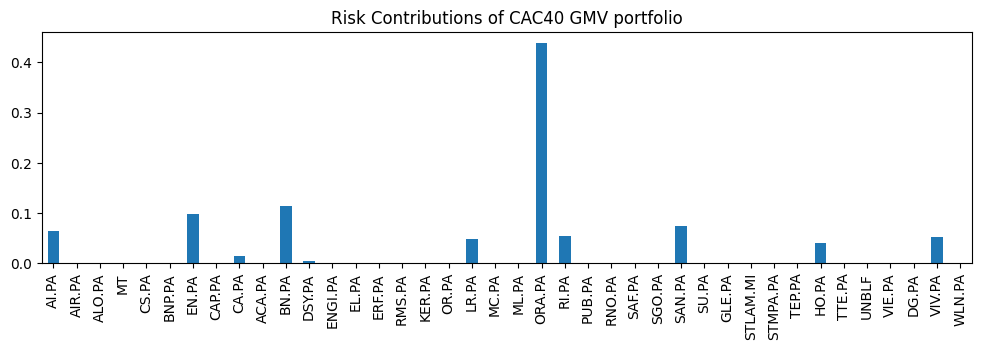

In [28]:
risk_contribution(weight_gmv(df_cac40_stocks_rets,
                             cov_estimator=shrinkage_cov,
                             delta=.5), cov).plot.bar(title="Risk Contributions of CAC40 GMV portfolio",
                                                      figsize=(12,3));

#### Find the set of weights $p_i$ that can achieve a given target risk

In [29]:
from scipy.optimize import minimize

def target_risk_contributions(target_risk, cov):
    """
    Returns the weights of the portfolio such that the contributions
    to portfolio risk (which depend on the covariance matrix) 
    are as close as possible to the target_risk
    """
    n = cov.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    def msd_risk(weights, target_risk, cov):
        """
        Returns the Mean Squared Difference in risk contributions
        between weights and target_risk
        """
        w_contribs = risk_contribution(weights, cov)
        return ((w_contribs-target_risk)**2).sum()
    
    # find the set of weights that minimizes the difference between target_risk 
    # (typically equal risk over all assets) and risks contributions given
    # by convariance matrix through risk_contribution(weights, cov)
    weights = minimize(msd_risk, init_guess,
                       args=(target_risk, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x

In [30]:
def equal_risk_contributions(cov):
    """
    Returns the weights of the portfolio that equalizes the contributions
    of the constituents based on the given covariance matrix
    """
    n = cov.shape[0]
    return target_risk_contributions(target_risk=np.repeat(1/n,n), cov=cov)

In [31]:
def weight_erc(r, cov_estimator, **kwargs):
    """
    Produces the weights of the ERC portfolio given a covariance matrix of the returns 
    """
    est_cov = cov_estimator(r, **kwargs)
    return equal_risk_contributions(est_cov)

ERC portfolio backtests with different estimators for the covariance matrix

In [32]:
erc_sample_r = backtest_ws(df_cac40_stocks_rets, 
                           estimation_window=estimation_window,
                           weighting=weight_erc,
                           cov_estimator=sample_cov)

erc_cc_r = backtest_ws(df_cac40_stocks_rets, 
                       estimation_window=estimation_window,
                       weighting=weight_erc,
                       cov_estimator=cc_cov)

erc_shrink_r = backtest_ws(df_cac40_stocks_rets,
                           estimation_window=estimation_window,
                           weighting=weight_erc,
                           cov_estimator=shrinkage_cov, delta=0.5)

In [50]:
# Benchmark DataFrame
# .loc[start_date:] to start at `start_date`
btr = pd.DataFrame({"CAC40 index (Cap Weighted)": df_cac40_rets['cac40_index'],
                    "Equal Weights": ew_r, 
                    "ERC-Sample": erc_sample_r,
                    "ERC-CC":erc_cc_r, 
                    "ERC-shrink 0.5":erc_shrink_r
                    }).loc[start_date:].dropna()

# .dropna() to drop NaNs in CAC40 index (some dates are missing even though the assets were traded)
summary_stats(btr, riskfree_rate=0.00, periods_per_year=252)

,Annualized Return,Annualized Vol,Skewness,Excess Kurtosis,Sharpe Ratio,Max Drawdown,Cornish-Fisher VaR (5%),Historic CVaR (5%)
CAC40 index (Cap Weighted),0.027883,0.194079,0.033209,3.744227,0.143667,-0.230398,0.018867,0.028553
Equal Weights,0.002728,0.190089,0.009646,3.468375,0.014354,-0.245809,0.018723,0.028281
ERC-Sample,0.021266,0.155803,0.294597,4.811178,0.136492,-0.207330,0.014206,0.022242
ERC-CC,0.027152,0.171604,0.015624,3.594890,0.158225,-0.208975,0.016766,0.025445
ERC-shrink 0.5,0.033891,0.157648,-0.091695,3.085682,0.214981,-0.194119,0.015776,0.023690


<Axes: title={'center': 'Backtesting Portfolios'}>

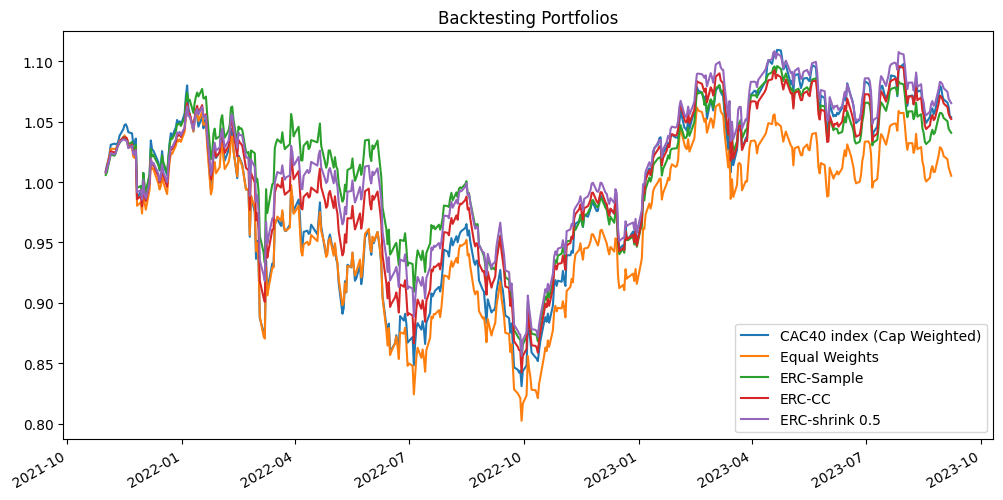

In [51]:
(1 + btr).cumprod().plot(figsize=(12,6), title="Backtesting Portfolios")

# Comparing portfolios<a id='comp'></a>

#### Weights allocations

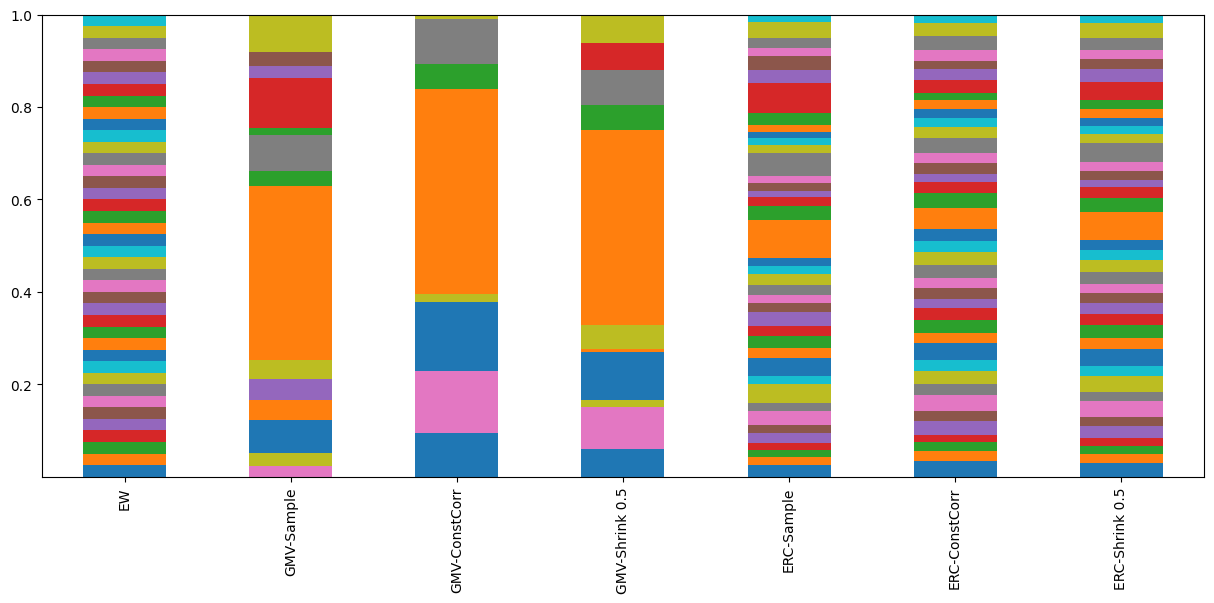

In [160]:
wts = pd.DataFrame({
    "EW": weight_ew(df_cac40_stocks_rets),
    "GMV-Sample": weight_gmv(df_cac40_stocks_rets, cov_estimator=sample_cov),
    "GMV-ConstCorr": weight_gmv(df_cac40_stocks_rets, cov_estimator=cc_cov),
    "GMV-Shrink 0.5": weight_gmv(df_cac40_stocks_rets, cov_estimator=shrinkage_cov, delta=0.5),
    "ERC-Sample": weight_erc(df_cac40_stocks_rets, cov_estimator=sample_cov),
    "ERC-ConstCorr": weight_erc(df_cac40_stocks_rets, cov_estimator=cc_cov),
    "ERC-Shrink 0.5": weight_erc(df_cac40_stocks_rets, cov_estimator=shrinkage_cov, delta=0.5),
})
wts.T.plot.bar(stacked=True, figsize=(15,6), legend=False);

#### Distributions of returns

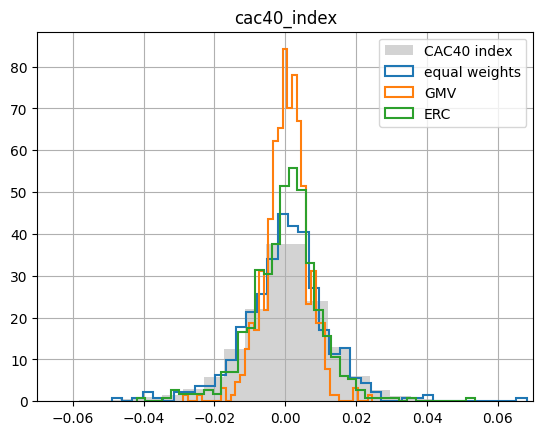

In [52]:
bins = 40
lw = 1.5
ax = df_cac40_rets.hist(bins=bins, density=True, lw=lw,  label='CAC40 index', color = "lightgrey")
ax = ew_r.hist(bins=bins, density=True, lw=lw, histtype='step', label='equal weights')
#ax = gmv_sample_r.hist(bins=bins, density=True, lw=lw, histtype='step', label='sampled')
#ax = gmv_cc_r.hist(bins=bins, density=True, lw=lw, histtype='step', label='sampled')
ax = gmv_shrink.hist(bins=bins, density=True, lw=lw, histtype='step', label='GMV')
ax = erc_shrink_r.hist(bins=bins, density=True, lw=lw, histtype='step', label='ERC')
ax.set_xlim(-0.07, 0.07)
ax.legend()

#### Summary statistics

In [52]:
# Benchmark DataFrame
# .loc[start_date:] to start at `start_date`
btr = pd.DataFrame({"CAC40 index (Cap Weighted)": df_cac40_rets['cac40_index'],
                    "Equal Weights": ew_r, 
                    "GMV-shrink 0.5":gmv_shrink,
                    "ERC-shrink 0.5":erc_shrink_r
                    }).loc[start_date:].dropna()

# .dropna() to drop NaNs in CAC40 index (some dates are missing even though the assets were traded)
summary_stats(btr, riskfree_rate=0.00, periods_per_year=252)

,Annualized Return,Annualized Vol,Skewness,Excess Kurtosis,Sharpe Ratio,Max Drawdown,Cornish-Fisher VaR (5%),Historic CVaR (5%)
CAC40 index (Cap Weighted),0.027883,0.194079,0.033209,3.744227,0.143667,-0.230398,0.018867,0.028553
Equal Weights,0.002728,0.190089,0.009646,3.468375,0.014354,-0.245809,0.018723,0.028281
GMV-shrink 0.5,0.094871,0.094762,-0.326988,2.145043,1.001150,-0.168936,0.009715,0.013325
ERC-shrink 0.5,0.033891,0.157648,-0.091695,3.085682,0.214981,-0.194119,0.015776,0.023690


<Axes: title={'center': 'Backtesting Portfolios'}>

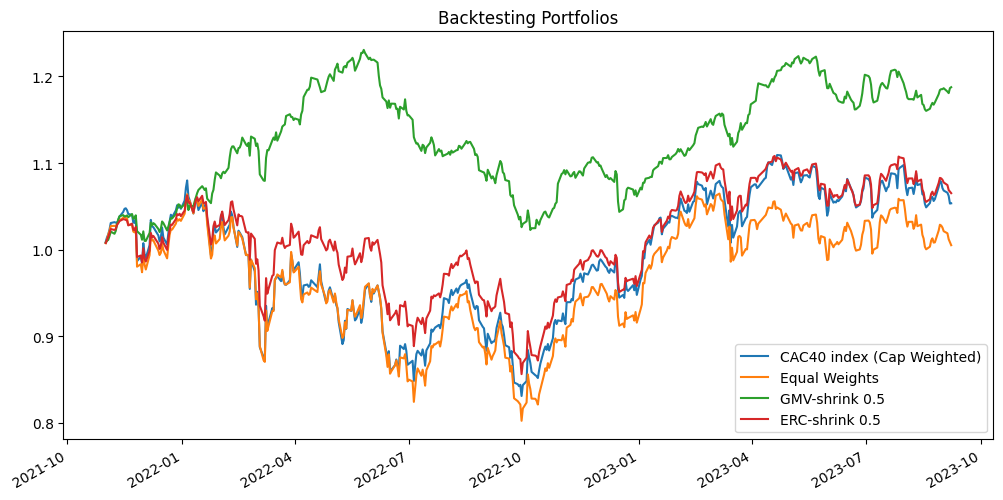

In [53]:
(1 + btr).cumprod().plot(figsize=(12,6), title="Backtesting Portfolios")